Importing Necessary Libraries 

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
from google.colab import files
data = files.upload()

Saving Final_data.csv to Final_data.csv


In [ ]:
data = pd.read_csv('Final_data.csv')

Encoding the positive sentiments as 1 and negative as 0

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
reviews = data['Reviews'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

Performing data preparation for training and test sets and importing evaluation metrics

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
train_sents, test_sents, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

Text preprocessing

In [ ]:
max_length = 500
embedding_dim = 50

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words = vocab, oov_token = '')
tokenizer.fit_on_texts(train_sents)
X_train_vocab = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sents)
X_train = pad_sequences(train_sequences, padding='post', maxlen=max_length)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sents)
X_test = pad_sequences(test_sequences, padding='post', maxlen=max_length)

Building the model

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Embedding, Dense, Flatten
from keras import Model

In [ ]:
input = Input(shape=(max_length,))
input.shape

TensorShape([None, 500])

In [ ]:
embedding_lyr =Embedding(len(X_train_vocab), embedding_dim)(input)
embedding_lyr.shape

TensorShape([None, 500, 50])

In [ ]:
lyr1 = Conv1D(32,3,activation = 'relu')(embedding_lyr)
lyr1.shape

TensorShape([None, 498, 32])

In [ ]:
lyr2 = MaxPooling1D(2)(lyr1)
lyr2.shape

TensorShape([None, 249, 32])

In [ ]:
lyr3 = Conv1D(32,3,activation = 'relu')(lyr2)
lyr3.shape

TensorShape([None, 247, 32])

In [ ]:
lyr4 = MaxPooling1D(2)(lyr3)
lyr4.shape

TensorShape([None, 123, 32])

In [ ]:
lyr5 = Flatten()(lyr4)
lyr5.shape

TensorShape([None, 3936])

In [ ]:
lyr6 = Dense(1000, activation = 'relu')(lyr5)
lyr6.shape

TensorShape([None, 1000])

In [ ]:
lyr7 = Dense(100, activation = 'relu')(lyr6)
lyr7.shape

TensorShape([None, 100])

In [ ]:
pred = Dense(1, activation = 'sigmoid')(lyr7)
pred.shape

TensorShape([None, 1])

In [ ]:
cnn_model = Model(input, pred)

In [ ]:
cnn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
cnn_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 500, 50)           4055150   
                                                                 
 conv1d_9 (Conv1D)           (None, 498, 32)           4832      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 249, 32)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 247, 32)           3104      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 123, 32)          0         
 1D)                                                       

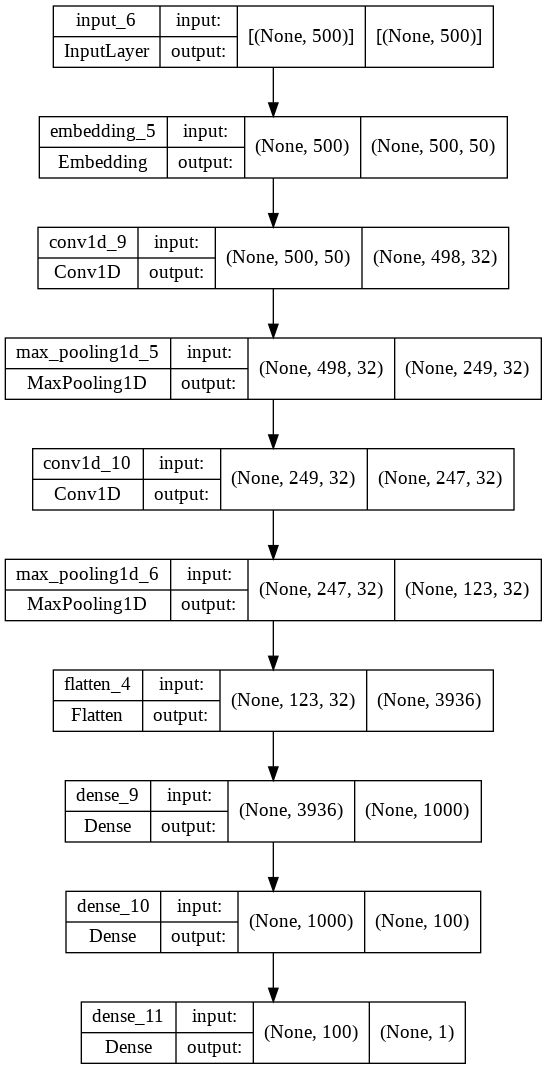

In [ ]:
tf.keras.utils.plot_model(
    cnn_model,
    to_file="cnn_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

Model Training

In [ ]:
num_epochs = 10
history = cnn_model.fit(X_train[:25000], train_labels[:25000], 
                    epochs=num_epochs, validation_data = ([X_train[25000:]], [train_labels[25000:]]))

Epoch 1/10
782/782 [==============================] - 77s 97ms/step - loss: 0.3835 - accuracy: 0.8146 - val_loss: 0.2718 - val_accuracy: 0.8950
Epoch 2/10
782/782 [==============================] - 76s 97ms/step - loss: 0.2193 - accuracy: 0.9172 - val_loss: 0.2635 - val_accuracy: 0.9019
Epoch 3/10
782/782 [==============================] - 74s 95ms/step - loss: 0.1624 - accuracy: 0.9412 - val_loss: 0.2797 - val_accuracy: 0.8873
Epoch 4/10
782/782 [==============================] - 75s 97ms/step - loss: 0.1105 - accuracy: 0.9624 - val_loss: 0.3058 - val_accuracy: 0.8896
Epoch 5/10
782/782 [==============================] - 74s 95ms/step - loss: 0.0683 - accuracy: 0.9786 - val_loss: 0.3970 - val_accuracy: 0.8839
Epoch 6/10
782/782 [==============================] - 75s 96ms/step - loss: 0.0428 - accuracy: 0.9882 - val_loss: 0.4898 - val_accuracy: 0.8865
Epoch 7/10
782/782 [==============================] - 74s 95ms/step - loss: 0.0292 - accuracy: 0.9924 - val_loss: 0.5595 - val_accuracy:

Time for Results!!

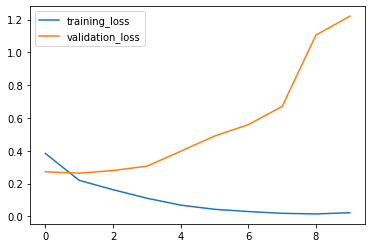

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

Performance on the test data (the unseen data)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
prediction = cnn_model.predict(X_test)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))


Accuracy of prediction on test set :  0.88008


In [ ]:
cf_matrix = confusion_matrix(test_labels, pred_labels)


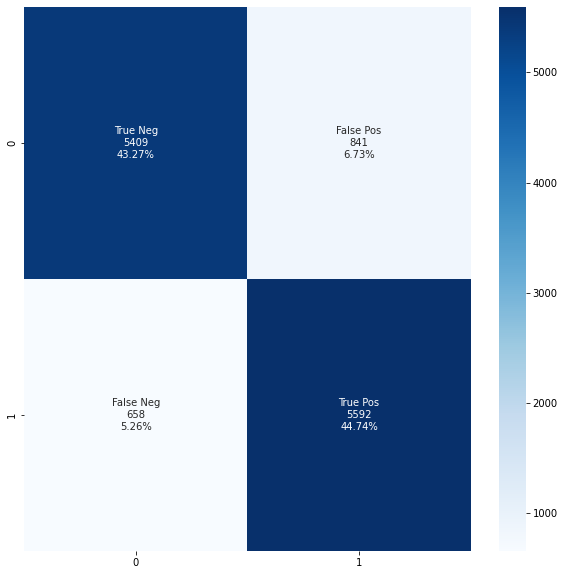

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)


sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_labels,pred_labels)

0.8818102972482852

In [ ]:
classification_report(test_labels,pred_labels)

'              precision    recall  f1-score   support\n\n           0       0.89      0.87      0.88      6250\n           1       0.87      0.89      0.88      6250\n\n    accuracy                           0.88     12500\n   macro avg       0.88      0.88      0.88     12500\nweighted avg       0.88      0.88      0.88     12500\n'

In [ ]:
""" 
                 precision    recall  f1-score   support

           0       0.89      0.87      0.88      6250
           1       0.87      0.89      0.88      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



"""